<a href="https://colab.research.google.com/github/KarineAyrs/science_work/blob/main/training/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [ ]:
!pip install segmentation-models-pytorch

In [3]:
import segmentation_models_pytorch as smp

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split

In [5]:
import os
from collections import OrderedDict
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt

In [9]:
config = {
         'device': torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
         'batch_size':2 ,
         'learning_rate': 0.001,
         'num_epochs':10,
         'encoder_name': 'resnet34',
         'encoder_weights':'imagenet'          
         }


In [10]:
config

{'batch_size': 2,
 'device': device(type='cuda', index=0),
 'encoder_name': 'resnet34',
 'encoder_weights': 'imagenet',
 'learning_rate': 0.001,
 'num_epochs': 10}

In [11]:
device=config['device']
batch_size=config['batch_size']
lr=config['learning_rate']
encoder_name = config['encoder_name']
encoder_weights = config['encoder_weights']
num_epochs = config['num_epochs']
img_dir = '/content/drive/MyDrive/Science work/CamSeq01'
H=W=512

In [12]:
print(device)

cuda:0


(720, 960, 3)


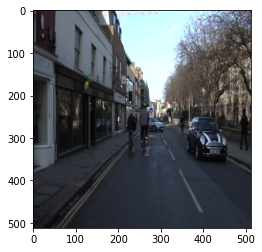

In [13]:
img = cv2.imread('/content/drive/MyDrive/Science work/CamSeq01/0016E5_07959.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)
img = cv2.resize(img, (512,512), interpolation = cv2.INTER_AREA)

plt.imshow(img)

In [15]:
color_codes = OrderedDict({
    'Animal':[64,128, 64], # R G B
    'Archway':[192, 0, 128],
    'Bicyclist':[0, 128, 192],
    'Bridge':[0, 128, 64],
    'Building':[128, 0, 0],
    'Car':[64,0,128],
    'CartLuggagePram':[64,0,192	],
    'Child':[192,128,64],
    'Column_Pole':[192,192,128],
    'Fence':[64,64,128],
    'LaneMkgsDriv':[128,0,192],
    'LaneMkgsNonDriv':[192,0,64],
    'Misc_Text':[128,128,64],
    'MotorcycleScooter':[192,0,192],
    'OtherMoving':[128,64,64],
    'ParkingBlock':[64,192,128],
    'Pedestrian':[64,64,0	],
    'Road':[128,64,128],
    'RoadShoulder':[128,128,192	],
    'Sidewalk':[0,0,192	],
    'SignSymbol':[192,128,128	],
    'Sky':[128,128,128],
    'SUVPickupTruck':[64,128,192],
    'TrafficCone':[0,0,64],
    'TrafficLight':[0,64,64	],
    'Train':[192,64,128],
    'Tree':[128,128,0],
    'Truck_Bus':[192,128,192],
    'Tunnel':[64,0,64],
    'VegetationMisc':[192,192,0],
    'Void':[0,0,0],
    'Wall':[64,192,0]    
})

	

In [16]:
class CSDataset(Dataset):
  def __init__(self, img_dir, color_codes, transforms=None, preprocessing=None, H=512, W=512):
    super().__init__()

    self.images = [os.path.join(img_dir, i)  for i in os.listdir(img_dir) if not i.split('.')[0].endswith('_L')] # paths to imgs
    self.masks = [os.path.join(img_dir, i)  for i in os.listdir(img_dir) if i.split('.')[0].endswith('_L')] # paths to masks
    self.color_codes = color_codes
    self.num_classe = len(self.color_codes)
    self.transforms=transforms
    self.preproc = preprocessing

  def __len__(self):
    return len(self.images)

  def __getitem__(self,idx):
    img = Image.open(self.images[idx]).convert('RGB')
    mask = Image.open(self.masks[idx]).convert('RGB')

    img = img.resize((H,W), Image.ANTIALIAS)
    mask = mask.resize((H,W), Image.ANTIALIAS)
   
    img = np.asarray(img)
    mask = np.asarray(mask)
    mask_channels = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int64)   


    for i, key_colour in enumerate(self.color_codes.keys()): 
      colour = self.color_codes[key_colour]
      sub_mask = np.all(mask==colour, axis=-1)*i 
      mask_channels += sub_mask #*i     
  
    if self.transforms is not None:
      transformed = self.transforms(image=img, mask=mask_channels)
      img = transformed['image']
      mask_channels=transformed['mask']  
    
    # if self.preproc is not None:
    #   preprocessed = self.preproc(image=img, mask = mask_channels)
    #   img = preprocessed['image']
    #   mask_channels=preprocessed['mask']
    
    instance = {'image': torch.from_numpy(img.transpose(2,0,1)), # channels first
                    'mask': torch.from_numpy(mask_channels)}

  
        
    return instance


In [17]:
def create_model(in_channels, classes, encoder_name='resnet34', encoder_weights='imagenet', activation='sigmoid'):
  model = smp.FPN(encoder_name=encoder_name, 
                        encoder_weights=encoder_weights, 
                        # in_channels=in_channels, 
                        classes=classes,
                        activation=activation)
  
  model.train()
  return model.float()


In [18]:
def train_model(model, train_loader, val_loader, device, optimizer, criterion= nn.CrossEntropyLoss(), num_epochs=1):

  model.to(device)
  model.train()
  
  for epoch in range(num_epochs):
    tr_loss = []
    val_loss = []
    print(f'Epoch {epoch}/{num_epochs}')

    for batch, sample in enumerate(train_loader):
      # if sample['image'].shape[0]==1:
      #   print('break')
      #   break
      inputs = sample['image'].to(device)
      masks = sample['mask'].to(device)

      optimizer.zero_grad()
      outputs = model(inputs.float())

      y_pred = outputs
      y_true = masks
      loss = criterion(y_pred.float(), y_true.long())
      loss.backward()
      tr_loss.append(loss)
      optimizer.step()

    print(f'Train loss: {torch.mean(torch.Tensor(tr_loss))}')

    for batch, sample in enumerate(val_loader):
        # if sample['image'].shape[0]==1:
        #   print('break')
        #   break
          inputs = sample['image'].to(device)
          masks = sample['mask'].to(device)

          optimizer.zero_grad()
          outputs = model(inputs.float())
          y_pred = outputs
          y_true = masks
          loss = criterion(y_pred.float(), y_true.long())
          loss.backward()
          tr_loss.append(loss)
          optimizer.step()

    print(f'Val loss: {torch.mean(torch.Tensor(tr_loss))}')
    

  return model

    


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model=create_model(3, len(color_codes), activation='softmax2d')

if torch.cuda.is_available():
    model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# preprocessing_fn = smp.encoders.get_preprocessing_fn(encoder_name=encoder_name, pretrained=encoder_weights)



In [20]:
dataset = CSDataset(img_dir = img_dir, color_codes=color_codes)

train_size = int(len(dataset)*0.85)
train_set, val_set = random_split(dataset, [train_size, len(dataset)-train_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [21]:
model = train_model(model,
                    train_loader,
                    val_loader,
                    device,
                    optimizer,
                    criterion,
                    num_epochs
                    )

Epoch 0/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train loss: 2.946702718734741
Val loss: 2.9328927993774414
Epoch 1/10
Train loss: 2.842179298400879
Val loss: 2.843588352203369
Epoch 2/10
Train loss: 2.82236385345459
Val loss: 2.8203909397125244
Epoch 3/10
Train loss: 2.806960105895996
Val loss: 2.8065969944000244
Epoch 4/10
Train loss: 2.7821552753448486
Val loss: 2.777904748916626
Epoch 5/10
Train loss: 2.7583045959472656
Val loss: 2.754260778427124
Epoch 6/10
Train loss: 2.741351842880249
Val loss: 2.7395780086517334
Epoch 7/10
Train loss: 2.7334938049316406
Val loss: 2.7318782806396484
Epoch 8/10
Train loss: 2.738165855407715
Val loss: 2.7358574867248535
Epoch 9/10
Train loss: 2.728255271911621
Val loss: 2.7264490127563477


In [22]:
model.eval()
for img in val_loader: 
  image = model(img['image'].float().to(device))
  break

dict_keys(['image', 'mask'])


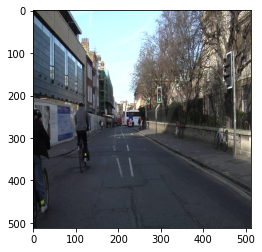

In [23]:
plt.imshow(img['image'][0].cpu().permute(1,2,0).numpy().astype(np.uint8));

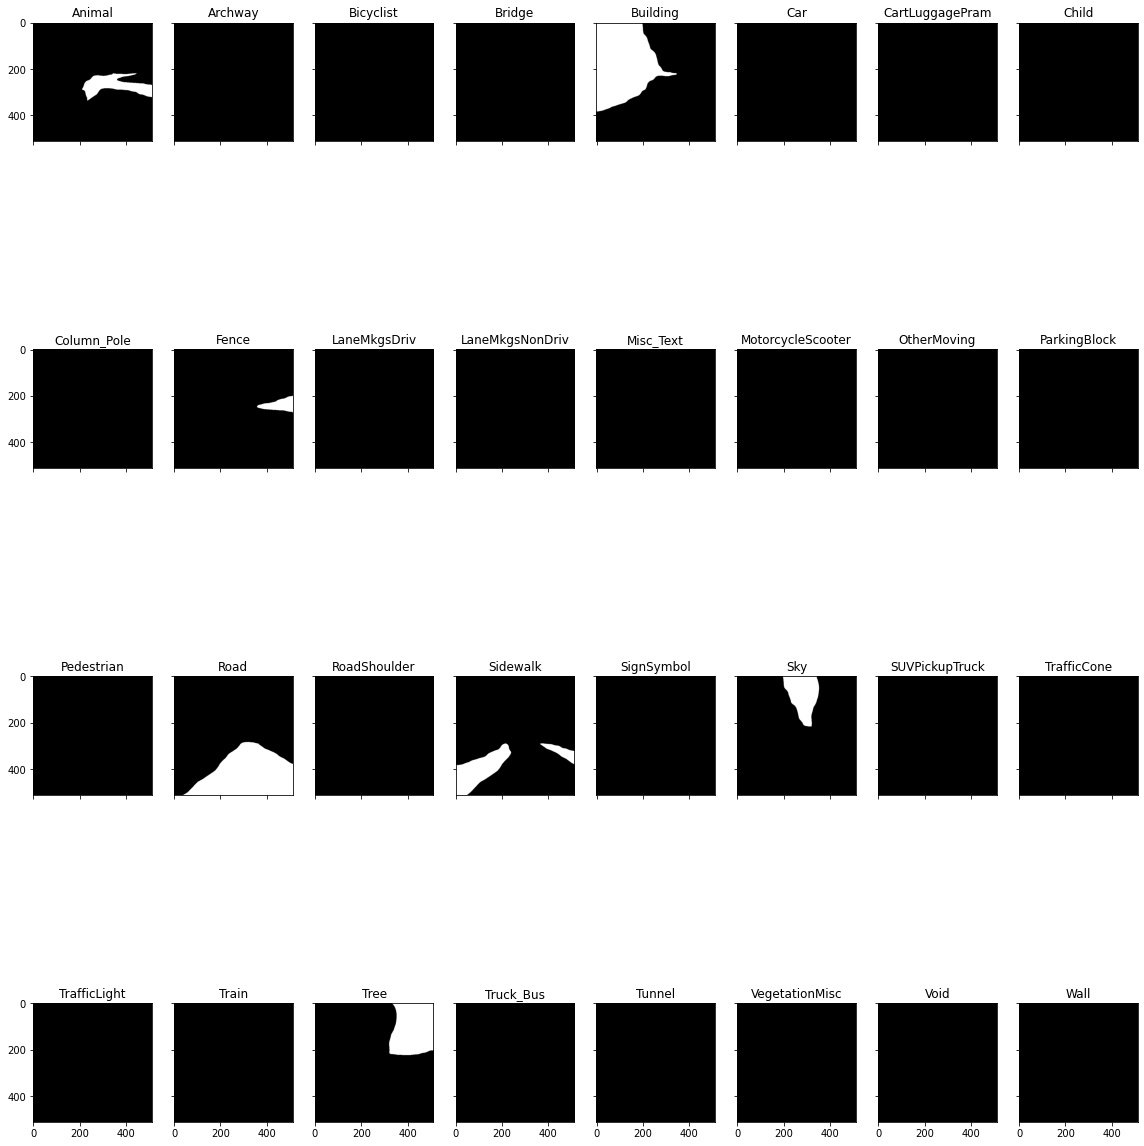

In [24]:
fig, axes = plt.subplots(nrows=4, ncols=8, sharex=True, sharey=True, figsize=(16,20)) 
axes_list = [item for sublist in axes for item in sublist]

thresh=0.3
res = image[0].detach().cpu().numpy()
for i, mask in enumerate(res):
    ax = axes_list.pop(0)
    ax.imshow(np.where(mask>thresh, 255, 0), cmap='gray')
    ax.set_title(list(color_codes.keys())[i])

for ax in axes_list: 
    ax.remove()
    
plt.tight_layout()